In [1]:
%matplotlib inline
from __future__ import division
import random
import numpy as np
import vcf
import gzip
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
import sys
import os
from Bio.Blast import NCBIXML
from Bio import SeqIO
import matplotlib
from matplotlib import pyplot as plt

In [2]:
def DansBlastParse(blast_xml_output, best_hit_criteria, Eval_thresh):
    """
    
    Usage: BlastParseExtra.py  <blast_xml_output>  <best_hit_criteria>  <Evalue_threshold>
    
    <blast_xml_output>  -  Path should be absolute
    <best_hit_criteria> -  Orders of magnitude higher that best hit has to be in multi
    <Evalue_threshold>  -  (1e-20 is default)
    
    
    This script first filters the mappings in the <blast_xml_output>, for only those where the
    best hit is at least 5 orders of magnitude higher than the second.
    
    It will then retrieve a segment of the <genome_fasta> which is + and - the <window_size> around the 
    mapping coordinates for each query. If the ends of the scaffold are not within this window, then the 
    length of the segment will be (length of mapped query sequence + 2 x <window_size>). However if an end
    of a scaffold is within this window, the segment will be trimmed to this length.
    
    """

    blast = NCBIXML.parse(open(blast_xml_output,"r"))

    good_blast_counts = 0
    uniq_counts = 0
    
    ## From Alan's script: Returns blast hits only when the best e-value is 5 orders of magnitude better than the second best.
    for record in blast :
        #print len(record.alignments)
        if len(record.alignments)==1:  ## Extra else statement - this wasn't in Alan's original script.
            if float(record.alignments[0].hsps[0].expect) < Eval_thresh:
                subject = str(record.alignments[0].hit_def)
                Evalue = float(record.alignments[0].hsps[0].expect)
                Hit_start_coord = int(record.alignments[0].hsps[0].sbjct_start)
                Hit_end_coord = int(record.alignments[0].hsps[0].sbjct_end)
                #print "Unique\t%s\t%s\t%s\t%s\t%s" % (record.query, subject, Evalue, Hit_start_coord, Hit_end_coord)
                good_blast_counts += 1
                uniq_counts += 1
        
        elif len(record.alignments)>1:
            if all([record.alignments[0].hsps[0].expect < best_hit_criteria * record.alignments[1].hsps[0].expect, record.alignments[0].hsps[0].expect <= Eval_thresh]):
                
                subject = str(record.alignments[0].hit_def)
                Evalue = float(record.alignments[0].hsps[0].expect)
                Hit_start_coord = int(record.alignments[0].hsps[0].sbjct_start)
                Hit_end_coord = int(record.alignments[0].hsps[0].sbjct_end)
                #print "Multi\t%s\t%s\t%s\t%s\t%s" % (record.query, subject, Evalue, Hit_start_coord, Hit_end_coord)
                good_blast_counts += 1


    #print "Number of good blast hits:", good_blast_counts
    #print "Number of unique mappings:", uniq_counts
    
    return good_blast_counts

1. Get sex linked tags
2. Get 10 sets of the same number of non-sex linked tags
3. blast all sets
4. take all hits with more than 20 hits over 1e-20 as TE hits
5. Plot N TE tags for each set

In [3]:
def TE_enrich(Sex_marker_path, VCF_path, catalog_path, TE_db, N_samples):
    
    SEXmarkers = open(Sex_marker_path, 'r').readlines()
    
    ## Get X linked marker IDs ----------------------------------------------------------------
    
    SEX_ids = []
    for line in SEXmarkers:
        if line.startswith(">"):
            SEX_ids.append(line.strip().split("_")[-1])

    N_SEXlinked_markers = len(SEX_ids)
    print "%s X-linked markers" % N_SEXlinked_markers
    
    
    ## Get all loci IDs

    VCF = open(VCF_path, 'r').readlines()

    All_loci = []

    for line in VCF:
        if not line.startswith("#"):
            All_loci.append(line.split()[2])
    All_loci = set(All_loci)

    ## Get only those that are non X-linked
    non_SEXlinked_loci = []
    
    for i in All_loci:
        if i not in SEX_ids:
            non_SEXlinked_loci.append(i)

    non_SEXlinked_loci = set(non_SEXlinked_loci)
    
    
    ## Make >N_samples< number of random sets of non sex linked markers (same number as N sex linked markers)
    
    Non_linked = {}
    for i in range(1,N_samples,1):

        Non_linked[i] = random.sample(non_SEXlinked_loci, N_SEXlinked_markers)
        
    
    ### Now for every set, make a fasta, blast to TE library and filter the outputs for good hits

    Non_SL_hits = []

    ## Make FASTAs
    catalog = open(catalog_path, 'r').readlines()
    
    outdir = catalog_path.rpartition("/")[0]

    for i in Non_linked:

        non_SL_fasta = open("%s/Non_sexlinked_%s.fasta" % (outdir,i),'w')
        loc_counter = 0
        for line in catalog:
            locID = line.split()[2]
            seq = line.split()[8]
            if locID in Non_linked[i]:
                loc_counter += 1
                non_SL_fasta.write(">%s\n%s\n" % (locID, seq))
        
        non_SL_fasta.close()

        blastout="%s/TE_blast_%s.xml" % (outdir,i)

        blastx_cline = NcbiblastnCommandline(query="%s/Non_sexlinked_%s.fasta" % (outdir,i), db= TE_db, \
        evalue=1e-20, outfmt=5, out= blastout)
        
        stdout, stderr = blastx_cline()

        Non_SL_hits.append(DansBlastParse(blastout, 1, 1e-20))

        if i in range(0, N_samples+1, int(N_samples/20)):
            print "processed %s subsamples . . . " % i
        elif i == N_samples:
            print "DONE"
    
    
    ## Now blast the SL markers
    
    SL_blastout="%s/TE_blast_%s.xml" % (outdir, "Xlinked")

    blastx_cline = NcbiblastnCommandline(query= Sex_marker_path , db= TE_db, \
    evalue=1e-20, outfmt=5, out= SL_blastout)
    stdout, stderr = blastx_cline()

    SEXlinked_hits = DansBlastParse(SL_blastout, 1, 1e-20)
    
    
    ## Now plot this info in a histogram and report means
    
    fig = plt.figure(figsize = (10,10))
    plt.hist(Non_SL_hits, color="royalblue")
    plt.vlines(SEXlinked_hits, 0, N_samples/4, linestyles='solid', colors="red" )
    plt.xlabel("N TE hits per loci subsample")
    plt.ylabel("N subsamples")
    plt.show()
    
    print "Mean number of Non sex linked loci that hit TEs = %s (+/- %s)" % (np.mean(Non_SL_hits), np.std(Non_SL_hits))
    print "Number of Sex linked marker that hit TEs = %s" % SEXlinked_hits
    

### Rarvalis (My analyses)

In [28]:
## Test parameters . . . 

Xmark_path = "/home/djeffrie/Data/RADseq/Rarvalis/Final_populations_outs/Putative_XYlinked_makers.fa"
VCF_pth = "/home/djeffrie/Data/RADseq/Rarvalis/Final_populations_outs/batch_1.vcf"
cat_path = "/home/djeffrie/Data/RADseq/Rarvalis/Final_populations_outs/batch_1.catalog.tags.tsv"
TE_DB = "/home/djeffrie/Desktop/For_Buisson/TEs/TE_catalog/Trinity.fasta"

316 X-linked markers
processed 10 subsamples . . . 
processed 20 subsamples . . . 
processed 30 subsamples . . . 
processed 40 subsamples . . . 
processed 50 subsamples . . . 
processed 60 subsamples . . . 
processed 70 subsamples . . . 
processed 80 subsamples . . . 
processed 90 subsamples . . . 
processed 100 subsamples . . . 
processed 110 subsamples . . . 
processed 120 subsamples . . . 
processed 130 subsamples . . . 
processed 140 subsamples . . . 
processed 150 subsamples . . . 
processed 160 subsamples . . . 
processed 170 subsamples . . . 
processed 180 subsamples . . . 
processed 190 subsamples . . . 


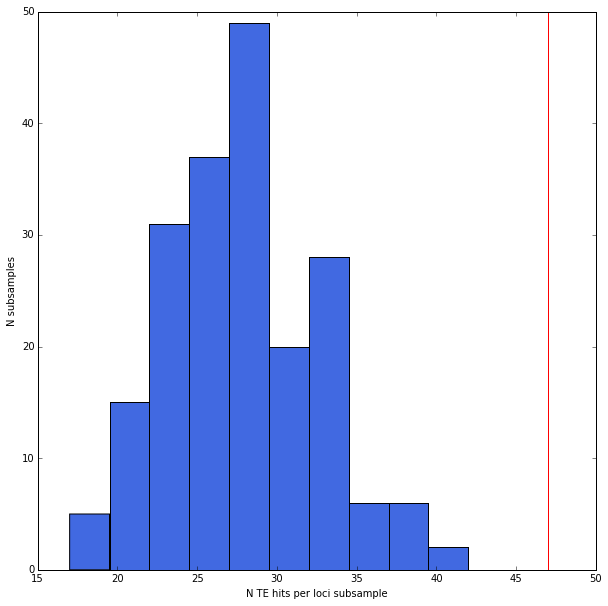

Mean number of Non sex linked loci that hit TEs = 27.5376884422 (+/- 4.7072420078)
Number of Sex linked marker that hit TEs = 47


In [29]:
TE_enrich(Xmark_path,VCF_pth, cat_path, TE_DB, 200) ## All sex linked

117 X-linked markers
processed 10 subsamples . . . 
processed 20 subsamples . . . 
processed 30 subsamples . . . 
processed 40 subsamples . . . 
processed 50 subsamples . . . 
processed 60 subsamples . . . 
processed 70 subsamples . . . 
processed 80 subsamples . . . 
processed 90 subsamples . . . 
processed 100 subsamples . . . 
processed 110 subsamples . . . 
processed 120 subsamples . . . 
processed 130 subsamples . . . 
processed 140 subsamples . . . 
processed 150 subsamples . . . 
processed 160 subsamples . . . 
processed 170 subsamples . . . 
processed 180 subsamples . . . 
processed 190 subsamples . . . 


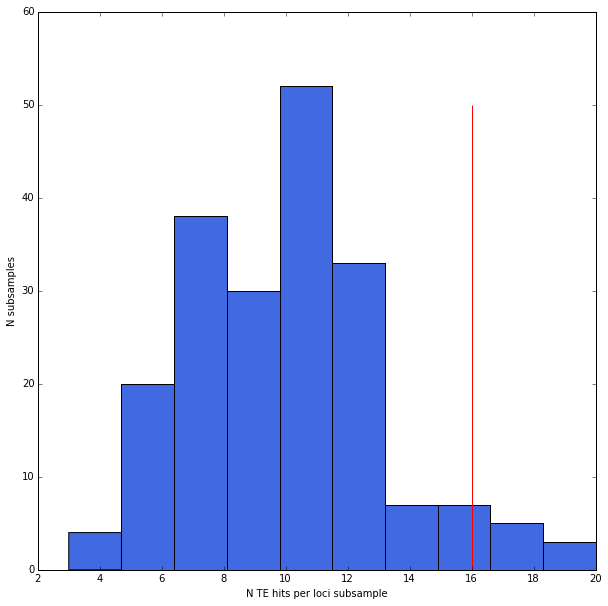

Mean number of Non sex linked loci that hit TEs = 9.97487437186 (+/- 3.08088153202)
Number of Sex linked marker that hit TEs = 16


In [31]:
Xmark_path = "/home/djeffrie/Data/RADseq/Rarvalis/Final_populations_outs/Y_linked_only.fasta"
TE_enrich(Xmark_path,VCF_pth, cat_path, TE_DB, 200) ## Y linked only

### Rdalmatina

In [16]:
## Test parameters . . . 

Xmark_path = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/Y_linked_only.fasta"
VCF_pth = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/batch_1.vcf"
cat_path = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/batch_1.catalog.tags.tsv"
TE_DB = "/home/djeffrie/Data/Transposable_elements/Rdal_RADtag_TE_enrichment_tests/Trinity.fasta"

31 X-linked markers
processed 10 subsamples . . . 
processed 20 subsamples . . . 
processed 30 subsamples . . . 
processed 40 subsamples . . . 
processed 50 subsamples . . . 
processed 60 subsamples . . . 
processed 70 subsamples . . . 
processed 80 subsamples . . . 
processed 90 subsamples . . . 
processed 100 subsamples . . . 
processed 110 subsamples . . . 
processed 120 subsamples . . . 
processed 130 subsamples . . . 
processed 140 subsamples . . . 
processed 150 subsamples . . . 
processed 160 subsamples . . . 
processed 170 subsamples . . . 
processed 180 subsamples . . . 
processed 190 subsamples . . . 


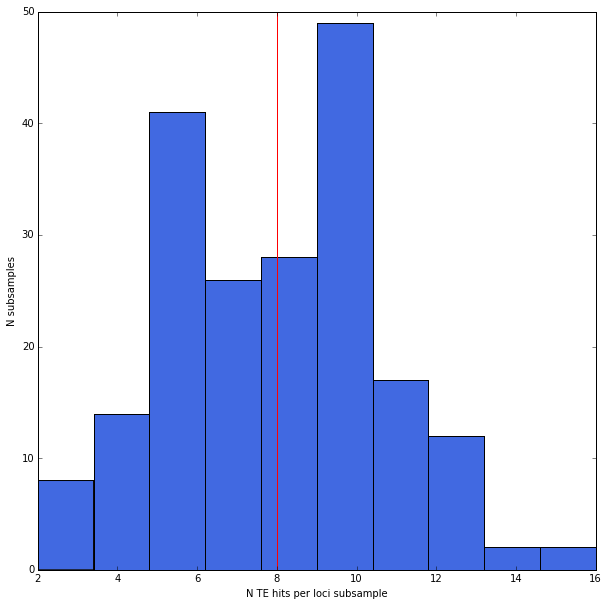

Mean number of Non sex linked loci that hit TEs = 7.86934673367 (+/- 2.60710568941)
Number of Sex linked marker that hit TEs = 8


In [17]:
TE_enrich(Xmark_path,VCF_pth, cat_path, TE_DB, 200) ## Y linked only

In [14]:
## Test parameters . . . 

Xmark_path = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/Putative_XYlinked_makers.fa"
VCF_pth = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/batch_1.vcf"
cat_path = "/home/djeffrie/Data/RADseq/Rdalmatina/Incremental/Populations_tests/batch_1.catalog.tags.tsv"
TE_DB = "/home/djeffrie/Data/Transposable_elements/Rdal_RADtag_TE_enrichment_tests/Trinity.fasta"

217 X-linked markers
processed 10 subsamples . . . 
processed 20 subsamples . . . 
processed 30 subsamples . . . 
processed 40 subsamples . . . 
processed 50 subsamples . . . 
processed 60 subsamples . . . 
processed 70 subsamples . . . 
processed 80 subsamples . . . 
processed 90 subsamples . . . 
processed 100 subsamples . . . 
processed 110 subsamples . . . 
processed 120 subsamples . . . 
processed 130 subsamples . . . 
processed 140 subsamples . . . 
processed 150 subsamples . . . 
processed 160 subsamples . . . 
processed 170 subsamples . . . 
processed 180 subsamples . . . 
processed 190 subsamples . . . 


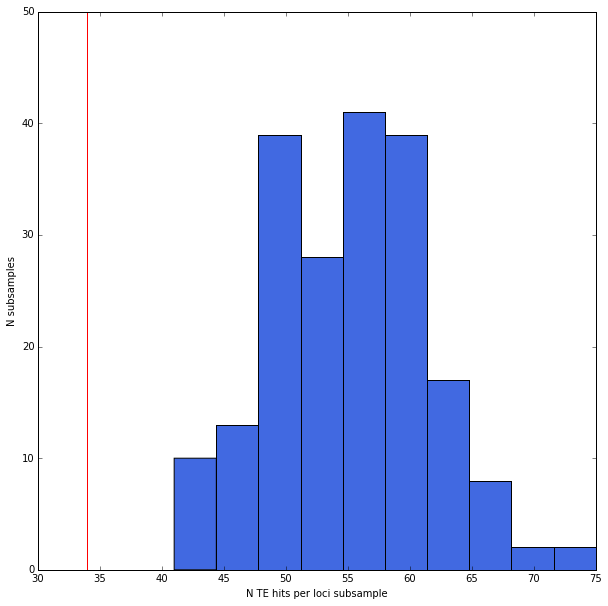

Mean number of Non sex linked loci that hit TEs = 54.9497487437 (+/- 6.3291212912)
Number of Sex linked marker that hit TEs = 34


In [15]:
TE_enrich(Xmark_path,VCF_pth, cat_path, TE_DB, 200) ## All sex linked markers

In [34]:
from scipy import stats

a = [2,3,4,3,2,3,4,2,3,3]
b = [6,7,6,7,8,7,6,7,8,6,4,5,3]

print stats.ttest_ind(a, b)
print np.mean(a)
print np.std(a)

print np.mean(b)
print np.std(b)

(-6.4092660739881957, 2.3633237802014072e-06)
2.9
0.7
6.15384615385
1.40582052942


Can continue to look for TE enrichment in the Y specific tags if there's time, but looking in the X linked tags is probably not so informative.